<h1>Определение перспективного тарифа</h1>  
  
«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. 
  
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов - 500 пользователей "Мегалайна". Выбрка содержит данные о том кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.  
  
**Задача:** анализ поведения клиентов, вывод о том, какой тариф лучше.

**Описание тарифов**

In [1]:
import pandas as pd #импорт библиотек
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

warnings.filterwarnings("ignore", category=DeprecationWarning)

try: #используем конструкцию try-except чтобы 100% прочитать файл
    tariffs_data = pd.read_csv('C:/Users/Полинария/Downloads/tariffs.csv', sep=',') #чтение локально
except:
    tariffs_data = pd.read_csv('/datasets/tariffs.csv', sep=',') #чтение файла на сервере
display(tariffs_data.head()) #знакомимся с данными

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<h1>Шаг 1. Просмотр файлов с данными и изучение общей информации</h1>  
  
На этом шаге просматриваю датасеты, изучаю общую информацию методами info() и describe().

In [2]:
try: #используем конструкцию try-except чтобы 100% прочитать файл
    calls_data = pd.read_csv('C:/Users/Полинария/Downloads/calls.csv', sep=',') #чтение локально
except:
    calls_data = pd.read_csv('/datasets/calls.csv', sep=',') #чтение файла на сервере
display(calls_data.head()) #знакомимся с данными
calls_data.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Радует, что в таблице с информацией о звонках нет пропущенных значений, однако можно сразу наметить себе фронт работ по calls_data:  
1. Столбец call_date привести к типу datetime
2. Округлить значения в столбце duration до минут, так как по условию "Мегалайн" всегда округляет секунды до минут.
3. Округленный столбец duration привести к типу int64

In [3]:
try: #используем конструкцию try-except чтобы 100% прочитать файл
    internet_data = pd.read_csv('C:/Users/Полинария/Downloads/internet.csv', sep=',') #чтение локально
except:
    internet_data = pd.read_csv('/datasets/internet.csv', sep=',') #чтение файла на сервере
display(internet_data.head()) #знакомимся с данными
internet_data.info()
internet_data.describe()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Снова вдохновляет отсутствие пропусков! И опять стоит отметить фронт работ с таблицей:  
1. Удалить столбец Unnamed, дублирующий индексы строк (вызвала метод describe() специально, чтобы убедиться, что это дубль индексов)
2. Перевести колонку с датой сессии в формат datetime. 
  
Мегабайты в гигабайты пока не переводим, так как округляется общее количество мегабайт за месяц. Поэтому перевод будем осуществлять уже после группировки по пользователям и месяцам.

In [4]:
internet_data = pd.read_csv('/datasets/internet.csv', sep=',', index_col=0) 
display(internet_data.head()) 

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [5]:
try: #используем конструкцию try-except чтобы 100% прочитать файл
    messages_data = pd.read_csv('C:/Users/Полинария/Downloads/messages.csv', sep=',') #чтение локально
except:
    messages_data = pd.read_csv('/datasets/messages.csv', sep=',') #чтение файла на сервере
display(messages_data.head()) #знакомимся с данными
messages_data.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропуски отсутствуют, действия такие же как с таблицей с данными по интернет-сессиям.

In [6]:
try: #используем конструкцию try-except чтобы 100% прочитать файл
    users_data = pd.read_csv('C:/Users/Полинария/Downloads/users.csv', sep=',') #чтение локально
except:
    users_data = pd.read_csv('/datasets/users.csv', sep=',') #чтение файла на сервере
display(users_data.head()) #знакомимся с данными
users_data.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Тоже все хорошо с данными, разве что переведем даты в нужный формат. Пропуски в колонке прекращения пользования тарифом нас не волнуют. Однако нас волнуют города пользователей, поэтому на всякий случай посмотрим список уникальных значений на наличие неочевидных дубликатов. Пользователей всего 50, так что метода unique() вполне достаточно.

In [7]:
users_data['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

<h1>Выводы по Шагу 1</h1>  
  
Открытие и первое знакомство с данными показало, что...нам повезло! Пропуски в данных отсутствуют, а значит не придется тратить время на их заполнение. В следущем шаге проведем запланированную обработку столбцов, на всякий случай проверим таблицы на дубликаты, а также добавим новые необходимые для анализа столбцы.

<h1>Шаг 2. Подготовка данных</h1>  
  
В этом разделе мы приведем данные к нужному виду, исправим ошибки, если они есть. Приведем данные к нужным типам и посчитаем необходимую дополнительную информацию.  
  
Пропусков данных мы не обнаружили, на всякий случай проверим таблицы на наличие явных дубликатов:

In [8]:
print('Дубликаты в данных о звонках:', calls_data.duplicated().sum())
print('Дубликаты в данных об интернет-сессиях:', internet_data.duplicated().sum())
print('Дубликаты в данных о сообщениях:', messages_data.duplicated().sum())
print('Дубликаты в данных о пользователях:', users_data.duplicated().sum())

Дубликаты в данных о звонках: 0
Дубликаты в данных об интернет-сессиях: 0
Дубликаты в данных о сообщениях: 0
Дубликаты в данных о пользователях: 0


Супер, дубликатов нет, что не может не радовать. Идем дальше - преобразуем всю информацию о датах в репрезентабельный вид. Сначала преобразуем данные столбцов в особый формат datetime, а потом отбросить год (так как все данные являются данными 2018 года) и число (оно нас не сильно волнует):

In [9]:
import math #импортируем math для округления
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')
calls_data['month'] = pd.DatetimeIndex(calls_data['call_date']).month #в будущем для работы мы будем использовать месяц, решила не перезаписывать столбец с полной датой- мало ли что
calls_data['duration'] = calls_data['duration'].apply(math.ceil) #округляем в большую сторону, как и планировали в шаге 1
calls_data.info() #проверки ради
display(calls_data.head()) #глазами всегда хочется посмотреть

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB


,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12


Теперь продулаем тоже самое с остальными таблицами и заодно удалим столбуц Unnamed, информация о котором дублирует индексы строк:

In [10]:
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
internet_data['month'] = pd.DatetimeIndex(internet_data['session_date']).month
#internet_data = internet_data.drop('Unnamed: 0', 1)
display(internet_data.head())
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
messages_data['month'] = pd.DatetimeIndex(messages_data['message_date']).month
display(messages_data.head())
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')
users_data['month'] = pd.DatetimeIndex(users_data['reg_date']).month
display(users_data.head())

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart,11
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra,8
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5


Теперь, когда данные приведены в порядок, посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам:

In [11]:
calls_data2 = calls_data.groupby(['user_id', 'month']).agg({'duration': 'count'}).reset_index() #используем группировку методом groupby, вытаскиваем ЧИСЛО звонков каждый месяц, пока не переписали основную таблицу
users_calls = calls_data.groupby(['user_id', 'month']).agg({'duration': 'sum'}).reset_index() # с помощью группировки переписываем и заменяем на нужную нам таблицу
users_calls['amount_of_calls'] = calls_data2['duration'] #помним, что тут у нас хранится ЧИСЛО звонков, а не суммарная продолжительность
display(users_calls.head()) #проверка

,user_id,month,duration,amount_of_calls
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


Отлично, нам удалось почитать количество и продолжительность звонков для каждого пользователя в разрезе по месяцам!  
  
Теперь посчитаем количество отправленных сообщений по месяцам:

In [12]:
users_messages = messages_data.groupby(['user_id', 'month']).agg({'id':'count'}).reset_index().rename(columns={'id':'amount_of_sms'}) #тут я додумалась решить проблему через id , а не как со звонками и переименовать колонку
display(users_messages.head())
print(users_messages['amount_of_sms'].mean())

,user_id,month,amount_of_sms
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


45.28376886271623


Далее посчитаем объем израсходованного интернет-трафика по месяцам:

In [13]:
users_internet = internet_data.groupby(['user_id', 'month']).agg({'mb_used':'sum'}).reset_index().rename(columns={'mb_used':'amount_of_mb'})
display(users_internet.head())
print(users_internet['amount_of_mb'].mean())

,user_id,month,amount_of_mb
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


17266.708626287855


Осталось посчитать помесячную выручку с каждого пользователя. Для этого из суммарного количества звонков, сообщений и интернет-трафика пользователя вычтем бесплатный лимит по тарифу. Все что сверх тарифа  - умножаем на значения тарифного плана, к получившемуся числу добавляем ежемесочную абонентскую плату:

In [14]:
df = users_calls.merge(users_messages, on=['user_id','month'], how='outer')#склеиваем сгруппированные таблицы в единый датафрейм, чтобы никого не потерять используем outer
df.head()

,user_id,month,duration,amount_of_calls,amount_of_sms
0,1000,5,159.0,22.0,22.0
1,1000,6,172.0,43.0,60.0
2,1000,7,340.0,47.0,75.0
3,1000,8,408.0,52.0,81.0
4,1000,9,466.0,58.0,57.0


In [15]:
df = df.merge(users_internet, on=['user_id','month'], how = 'outer') #добавляем интернет
df.tail()

,user_id,month,duration,amount_of_calls,amount_of_sms,amount_of_mb
3209,1489,9,NaN,NaN,32.0,17206.30
3210,1489,10,NaN,NaN,21.0,19559.44
3211,1489,11,NaN,NaN,20.0,17491.56
3212,1489,12,NaN,NaN,35.0,17322.51
3213,1476,4,NaN,NaN,NaN,530.78


In [16]:
df = df.merge(users_data[['user_id','tariff','city']], on=['user_id'], how ='left') #склеиваем с данными о пользователях
tariffs_data  = tariffs_data.rename(columns={'tariff_name':'tariff'})
df = df.merge(tariffs_data, on=['tariff'], how ='left') #склеиваем с данными о тарифах
df.fillna(0, inplace = True) #для расчета в пропусках поставим нули, так как отсутсвие значение соответсвует нулевому использованию услуги
df.head()

,user_id,month,duration,amount_of_calls,amount_of_sms,amount_of_mb,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2253.49,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23233.77,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14003.64,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14055.93,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14568.91,ultra,Краснодар,1000,30720,3000,1950,150,1,1


Теперь напишем функцию, которая будет считать стоимость превышения лимитов по тарифу:

In [17]:
def above_the_tariff(row):
    sms = (row['amount_of_sms'] - row['messages_included']) * row['rub_per_message']
    mins = (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    mbs = np.ceil((row['amount_of_mb'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024)
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total

Применяем нашу функцию и считаем сколько было получено с пользователя всего:

In [18]:
df['above_the_tariff'] = df.apply(lambda x: above_the_tariff(x), axis=1) 
df['total_paid'] = df['rub_monthly_fee'] + df['above_the_tariff']
df.tail()

,user_id,month,duration,amount_of_calls,amount_of_sms,amount_of_mb,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
3209,1489,9,0.0,0.0,32.0,17206.30,smart,Санкт-Петербург,50,15360,500,550,200,3,3,361.0,911.0
3210,1489,10,0.0,0.0,21.0,19559.44,smart,Санкт-Петербург,50,15360,500,550,200,3,3,821.0,1371.0
3211,1489,11,0.0,0.0,20.0,17491.56,smart,Санкт-Петербург,50,15360,500,550,200,3,3,417.0,967.0
3212,1489,12,0.0,0.0,35.0,17322.51,smart,Санкт-Петербург,50,15360,500,550,200,3,3,384.0,934.0
3213,1476,4,0.0,0.0,0.0,530.78,ultra,Москва,1000,30720,3000,1950,150,1,1,0.0,1950.0


<h1>Выводы по Шагу 2</h1>  
  
В ходе подготовки данныхт мы сгурппировали данные и подготовили к анализу, а так же выяснили сколько платят пользователи за пользование тарифом в разрезе по месяцам.

In [19]:
display(internet_data.query('mb_used == 0').head())
display(internet_data[internet_data['mb_used'] == 0]['mb_used'].count())

,id,mb_used,session_date,user_id,month
11,1000_11,0.0,2018-08-28,1000,8
38,1000_38,0.0,2018-11-27,1000,11
46,1000_46,0.0,2018-06-30,1000,6
67,1000_67,0.0,2018-06-16,1000,6
72,1000_72,0.0,2018-06-15,1000,6


19598


<b>Продолжаем рассуждать</b>
    
Пока нет идей закономерности возникновения нулей. Однако их доля среди всех наблюдений достаточно мала - 13%. Возможно это просто ошибочные сессии, например человек просто открывал браузер или нечто подобное, либо в тариф бывают включены бесплатные мессенджеры, которые могут засчитываться как 0, чтобы потом не учитывать их при расчете.  
    На самом деле для нас эти 0 не играют критической роли при последующем анализе -> так как они все равно схлопываются при группировке, возможно поэтому я не стала обращать на них внимания. В связи с последующей группировкой их можно не удалять, посчитав ошибочными сессиями.  
    Однако любопытсва ради глянем их распределение по месяцам и по пользователям :D
</div>

In [20]:
zero_usage = internet_data.query('mb_used == 0').groupby(['user_id', 'month']).agg({'mb_used':'count'}).reset_index().rename(columns={'mb_used':'zero_sessions'})
display(zero_usage.head())

,user_id,month,zero_sessions
0,1000,5,1
1,1000,6,5
2,1000,7,1
3,1000,8,2
4,1000,9,2


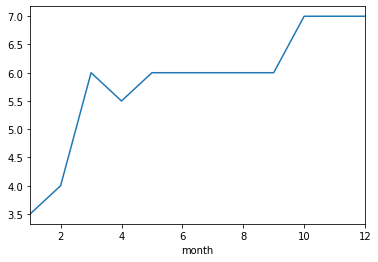

In [21]:
zero_usage.groupby('month')['zero_sessions'].median().plot()

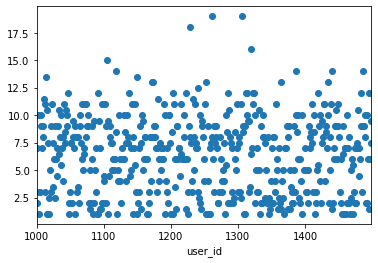

In [22]:
zero_usage.groupby('user_id')['zero_sessions'].median().plot(style ='o')


<b>Мой вывод</b>

Идей закономерности после просмотра графиков так и не появилось, думаю их природа действительно случайна, что в целом подтверждает график зависимости количества нулевых сессий от месяца (с каждым новым месяцем больше пользователей, соответсвенно и ошибочных сессий). В любом случае от этих нулей не нужно избавляться, так как они все ранво схлопнутся при дальнейшей работе и никак не повлияют на выводы :D
</div>

<h1>Шаг 3. Анализ данных</h1>  

На этом шаге опишем поведение клиентов оператора, исходя из выборки. Покажем сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитайтем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы и опишем распределения.

Основная таблица для анализа сформирована - df, приступим к ее анализу. Для начала построим диаграммы размаха, изучиим выбросы, по необходимости - избавимся от них.

In [23]:
df[['above_the_tariff', 'total_paid']].describe()

,above_the_tariff,total_paid
count,3214.000000,3214.000000
mean,505.805538,1484.865899
std,732.212483,782.973144
min,0.000000,550.000000
25%,0.000000,692.250000
50%,105.000000,1558.500000
75%,836.000000,1950.000000
max,6150.000000,6700.000000


duration            AxesSubplot(0.125,0.125;0.227941x0.755)
amount_of_mb     AxesSubplot(0.398529,0.125;0.227941x0.755)
amount_of_sms    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

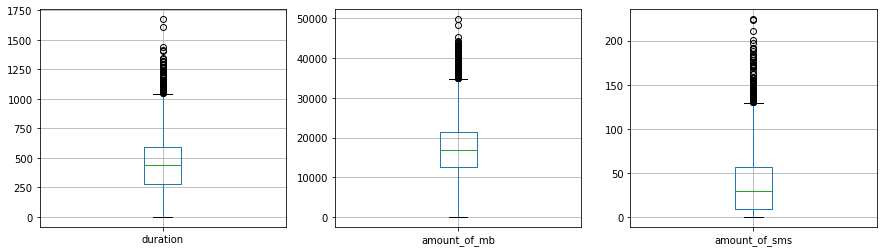

In [24]:
columns = ['duration', 'amount_of_mb', 'amount_of_sms']
df[columns].plot(subplots=True, layout=(1, 3), kind = 'box', figsize=(15, 4), grid=True)

Теперь рассчитаем границы выбросов:

In [25]:
for column in columns:
    print('------------------------\nСтолбец {}\n------------------------'.format(column))
    q1=df[column].describe()[4]
    q3=df[column].describe()[6]
    iqr = q3 - q1
    top_edge = q3 + 1.5 * iqr
    print ('Верхняя граница {}'.format(top_edge))
    display(df[column].describe())

------------------------
Столбец duration
------------------------
Верхняя граница 1049.5


count    3214.000000
mean      451.244866
std       241.909978
min         0.000000
25%       282.000000
50%       443.000000
75%       589.000000
max      1673.000000
Name: duration, dtype: float64

------------------------
Столбец amount_of_mb
------------------------
Верхняя граница 34823.72749999999


count     3214.000000
mean     17207.612859
std       7570.958771
min          0.000000
25%      12491.890000
50%      16943.175000
75%      21424.625000
max      49745.690000
Name: amount_of_mb, dtype: float64

------------------------
Столбец amount_of_sms
------------------------
Верхняя граница 129.0


count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: amount_of_sms, dtype: float64

Теперь мы можем убрать все выбросы из нашей выборки, чтобы остались только наиболее типичные значения. Таким образом, мы считаем выбросами: звонки, которые продолжались более 1050 минут, объем трафика выше 34824 мб, сообщения, число которых превышает 129:

In [26]:
df_filtered = df.query('duration < 1050 and amount_of_mb < 34824 and amount_of_sms < 129')

duration            AxesSubplot(0.125,0.125;0.227941x0.755)
amount_of_mb     AxesSubplot(0.398529,0.125;0.227941x0.755)
amount_of_sms    AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

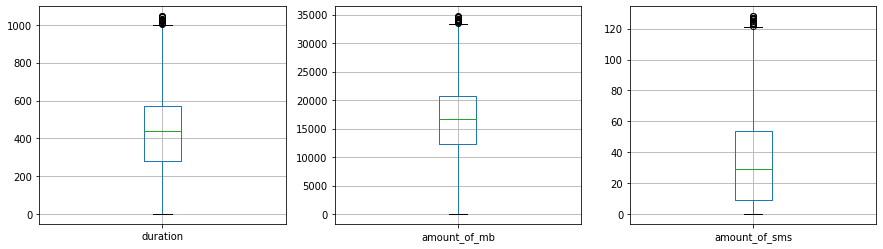

In [27]:
df_filtered[columns].plot(subplots=True, layout=(1, 3), kind = 'box', figsize=(15, 4), grid=True)

Посмотрим на сколько строк изменилась выборка:

In [28]:
display(df.shape[0] - df_filtered.shape[0])

206

Теперь приведем тип данных к целочисленному типу:

In [44]:
df_filtered[columns] = df_filtered[columns].astype('int64')
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3008 entries, 0 to 3213
Data columns (total 17 columns):
user_id                  3008 non-null int64
month                    3008 non-null int64
duration                 3008 non-null int64
amount_of_calls          3008 non-null int64
amount_of_sms            3008 non-null int64
amount_of_mb             3008 non-null int64
tariff                   3008 non-null object
city                     3008 non-null object
messages_included        3008 non-null int64
mb_per_month_included    3008 non-null int64
minutes_included         3008 non-null int64
rub_monthly_fee          3008 non-null int64
rub_per_gb               3008 non-null int64
rub_per_message          3008 non-null int64
rub_per_minute           3008 non-null int64
above_the_tariff         3008 non-null float64
total_paid               3008 non-null float64
dtypes: float64(2), int64(13), object(2)
memory usage: 423.0+ KB


Замечаем, что количество звонков тоже надо привести к целочисленному типу:

In [45]:
df_filtered['amount_of_calls'] = df_filtered['amount_of_calls'].astype('int64')
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3008 entries, 0 to 3213
Data columns (total 17 columns):
user_id                  3008 non-null int64
month                    3008 non-null int64
duration                 3008 non-null int64
amount_of_calls          3008 non-null int64
amount_of_sms            3008 non-null int64
amount_of_mb             3008 non-null int64
tariff                   3008 non-null object
city                     3008 non-null object
messages_included        3008 non-null int64
mb_per_month_included    3008 non-null int64
minutes_included         3008 non-null int64
rub_monthly_fee          3008 non-null int64
rub_per_gb               3008 non-null int64
rub_per_message          3008 non-null int64
rub_per_minute           3008 non-null int64
above_the_tariff         3008 non-null float64
total_paid               3008 non-null float64
dtypes: float64(2), int64(13), object(2)
memory usage: 423.0+ KB


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Теперь можно перейти к изучению особенностей пользователей в зависимости от тарифа. Сначала узнаем какую долю от общего числа пользователей составляют пользователи каждого тарифа:

tariff
smart    351
ultra    149
Name: tariff, dtype: int64

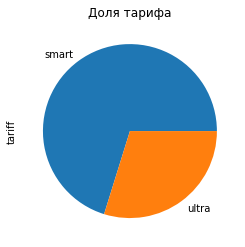

In [31]:
display(users_data.groupby('tariff')['tariff'].count())
users_data.groupby('tariff')['tariff'].count().plot(kind='pie',  title='Доля тарифа')

Пользователи тарифа Ультра составляют чуть более четверти всех пользователей выборки. Рассмотрим все таки разницу в поведении исходя из продолжительности звонков, трафика и сообщений. 

In [32]:
df_filtered_smart = pd.pivot_table(data=df_filtered.loc[df['tariff']=='smart'], index = 'month', values=columns, aggfunc=sum)
display(df_filtered_smart)

,amount_of_mb,amount_of_sms,duration
month,,,
1,289448,620,6931
2,672598,1397,17324
3,1162983,2453,30034
4,1507706,3443,41119
5,2228458,4762,54618
6,2564272,5344,64128
7,3144184,6647,81360
8,3879842,7771,98263
9,4215270,8610,110724


Видно, как из месяца в месяц растет продолжительность звонков, трафика и смс, скорее всего это связано с ростом пользователей тарифа. Посмотрим на графике:

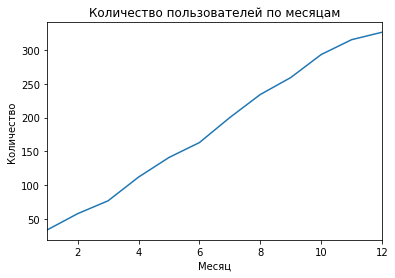

In [33]:
df_filtered.loc[df_filtered['tariff']=='smart'].groupby('month')['user_id'].count().plot()
plt.title('Количество пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.show()

Видно, что с каждым весяцем к тарифу подключалось все больше пользователей. Интересно, а есть ли такой же равномерный рост популярности у тарифа Ультра? Но сначала рассчитаем среднее, дисперсию и стандартное отклонение, но уже без группировки по месяцам:

In [34]:
df_filtered.loc[df_filtered['tariff']=='smart'].describe() 

,user_id,month,duration,amount_of_calls,amount_of_sms,amount_of_mb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
count,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.000000,2212.0,2212.0,2212.0,2212.0,2212.0,2212.0,2212.0,2212.000000,2212.000000
mean,1246.260398,8.328210,415.046112,58.063291,32.995931,16112.390145,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,658.170434,1208.170434
std,146.242044,2.918749,186.940935,25.488490,27.630771,5756.455350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,735.869857,735.869857
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,0.000000,550.000000
25%,1121.000000,6.000000,281.000000,40.000000,10.000000,12615.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,0.000000,550.000000
50%,1239.000000,9.000000,420.000000,59.000000,28.000000,16457.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,404.000000,954.000000
75%,1376.000000,11.000000,543.000000,76.000000,50.000000,19974.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,1097.000000,1647.000000
max,1499.000000,12.000000,1022.000000,137.000000,127.000000,33886.000000,50.0,15360.0,500.0,550.0,200.0,3.0,3.0,4063.000000,4613.000000


Теперь проделаем все тоже самое с пользователями тарифа Ультра, а затем посмотрим разницу поведения.

,amount_of_mb,amount_of_sms,duration
month,,,
1,118263,304,3853
2,282610,527,7131
3,513603,741,13149
4,813361,1446,22821
5,1060482,2030,29244
6,1292630,2534,33770
7,1143313,2617,34729
8,1517158,3512,41478
9,1688649,3732,45351


,user_id,month,duration,amount_of_calls,amount_of_sms,amount_of_mb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
count,796.000000,796.000000,796.000000,796.000000,796.000000,796.000000,796.0,796.0,796.0,796.0,796.0,796.0,796.0,796.000000,796.000000
mean,1267.194724,8.064070,483.312814,67.437186,39.162060,17441.565327,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,19.192211,1969.192211
std,144.353065,2.924572,266.633891,37.109423,35.462162,8707.129348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.416449,83.416449
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,0.000000,1950.000000
25%,1126.000000,6.000000,280.500000,40.000000,4.000000,10762.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,0.000000,1950.000000
50%,1292.000000,8.000000,497.500000,69.000000,31.000000,17404.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,0.000000,1950.000000
75%,1385.000000,11.000000,683.250000,94.250000,65.000000,23861.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,0.000000,1950.000000
max,1495.000000,12.000000,1045.000000,165.000000,128.000000,34709.000000,1000.0,30720.0,3000.0,1950.0,150.0,1.0,1.0,585.000000,2535.000000


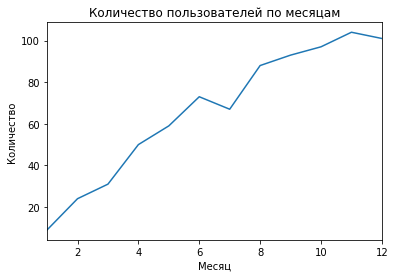

In [35]:
df_filtered_ultra = pd.pivot_table(data=df_filtered.loc[df['tariff']=='ultra'], index = 'month', values=columns, aggfunc=sum)
display(df_filtered_ultra)
display(df_filtered.loc[df_filtered['tariff']=='ultra'].describe())
df_filtered.loc[df_filtered['tariff']=='ultra'].groupby('month')['user_id'].count().plot()
plt.title('Количество пользователей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество')
plt.show()

Популярность тарифа ультра растет не так же гладко, как тарифа смарт - в опредленные месяцы даже есть уменьшение числа пользователей относительно предыдущего периода. Однако, средние значения потребления услуг не сильно отличаются - рассмотрим точнее разницу среднего и медианы у двух тарифов:

In [36]:
df_filtered_smart = df_filtered.loc[df_filtered['tariff']=='smart']
df_filtered_ultra = df_filtered.loc[df_filtered['tariff']=='ultra']
for column in columns:
    mean_difference = round(df_filtered_smart[column].describe()[1] - df_filtered_ultra[column].describe()[1], ndigits=1)
    median_difference = round(df_filtered_smart[column].describe()[5] - df_filtered_ultra[column].describe()[5], ndigits=1)
    print('Среднее значение {} тарифа smart отличается от  ultra на {}'.format(column, mean_difference))
    print('Медиана {} тарифа smart отличается от  ultra на {}\n'.format(column, median_difference))

Среднее значение duration тарифа smart отличается от  ultra на -68.3
Медиана duration тарифа smart отличается от  ultra на -77.5

Среднее значение amount_of_mb тарифа smart отличается от  ultra на -1329.2
Медиана amount_of_mb тарифа smart отличается от  ultra на -947.0

Среднее значение amount_of_sms тарифа smart отличается от  ultra на -6.2
Медиана amount_of_sms тарифа smart отличается от  ultra на -3.0



Сразу стало видно, что пользователи тарифа Ультра не зря переплачивают за абонентскую плату: среднее потребление по всем направлениям у них выше, чем у пользователей тарифа Смарт: в среднем они говорят дольше на час, потребляют на гигабайт больше интернета и совсем незначительно (смски видимо у всех уже не в почете) больше отправляют смс.

Теперь посмотрим на распредление - построим гистограммы плотности для каждого показателя по обоим тарифам:

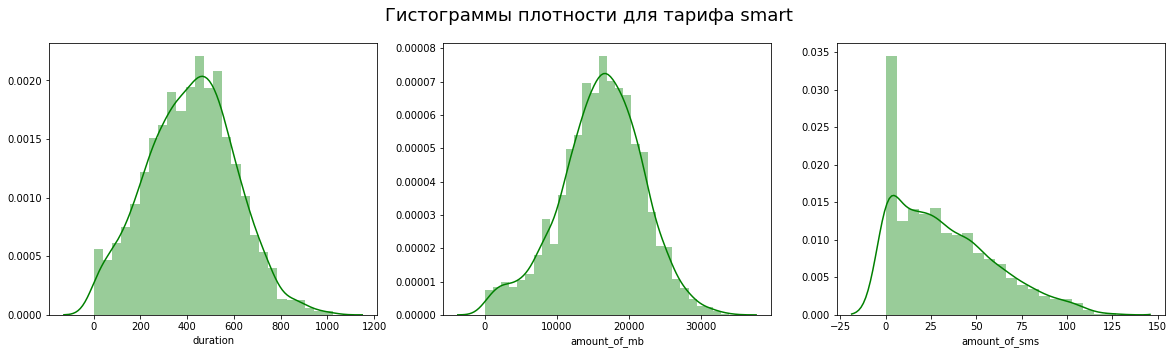

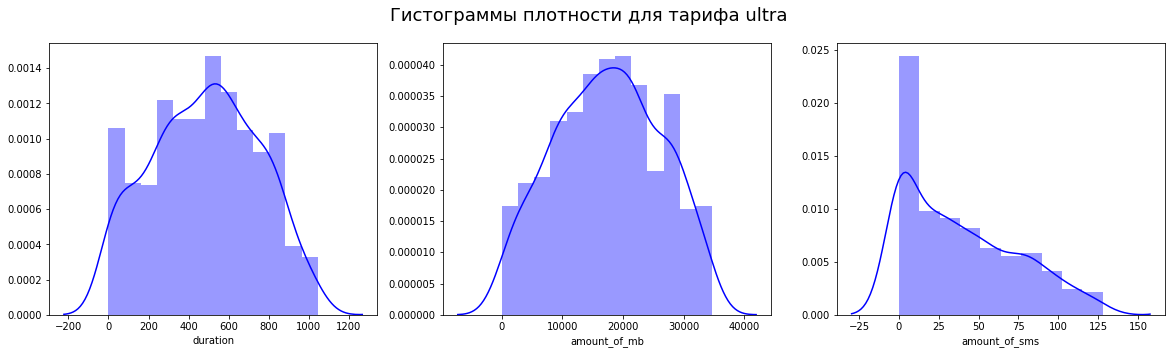

In [37]:
fig, axs = plt.subplots(1,3, figsize=[20,5])
fig.suptitle('Гистограммы плотности для тарифа smart',fontsize=18)
for i, column in enumerate(columns):
    sns.distplot(df_filtered_smart[column], ax=axs[i], color='green')
    
plt.show()

fig, axs = plt.subplots(1,3, figsize=[20,5])
fig.suptitle('Гистограммы плотности для тарифа ultra',fontsize=18)
for i, column in enumerate(columns):
    sns.distplot(df_filtered_ultra[column], ax=axs[i], color='blue')

<h1>Выводы по Шагу 3</h1>  


Распредления тарифов очень похожи из этого следует, что пользователи ведут себя примерно одинакого.Гистограммы плотности сообщений ассиметричены в обоих случаях, так как это непопулярная услуга. Колокол гистограмм продолжительности звонков и количества мегабайт на тарифе Ультра шире, так как он включает в себя больше услуг и потребление на этом тарифе больше.

<h1>Шаг 4. Проверка гипотез</h1>  

Проверка гипотез:  
•	средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;  
•	средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


Поясните:  
•	как вы формулировали нулевую и альтернативную гипотезы;  
•	какой критерий использовали для проверки гипотез и почему.


Приступаем к проверки гипотез, превая - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.  Будем проверять две генеральные совокупности на равенство их средних (st.ttest_ind). Считаем, что первая генеральная совокупность - пользователи тарифа smart, вторая - ultra. В каждой выборке достаточно наблюдений, чтобы применить t-критерий. Формулируем гипотезы исходя из того, что первая гипотеза - всегда со знаком равенства:

Н0 - средняя выручка компании от пользователей тарифов «Ультра» и «Смарт» одинаковая  
H1 - средняя выручка компании от пользователей тарифов «Ультра» и «Смарт» отличается

В целях понимания значения аргумента equal_var  метода st.ttest_ind сравним дисперсии:

In [38]:
ultra = df_filtered.query("tariff == 'ultra'")
smart = df_filtered.query("tariff == 'smart'")
print(int(smart['total_paid'].describe()[2])**2)
print(int(ultra['total_paid'].describe()[2])**2)


540225
6889


Исходя из разницы дисперсий для проведения t-теста в методе пропишем аргумент equal_var=False. Уровень значимости зададим равным 5%:

In [39]:
from scipy import stats as st
alpha = 0.05
result = st.ttest_ind(smart['total_paid'], ultra['total_paid'], equal_var=False)

print('p-значение:',result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Таким образом, Н0 отвергается, средняя выручка компании от тарифов Смарт и Ультра отличается.  

Проверим вторую гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.  
Тест проведем по аналогии с предыдущим, пользователи из Москвы одна генеральная совокупность, жители остальных городов - принадлежат к другой. Проверим равенство дисперсий и затем проверим гипотезу:  
Н0 - средняя выручка компании в Москве равна выручке из других регионов  
H1 - средняя выручка компании в Москвы НЕ равна выручке из других регионов

In [40]:
moscow_revenue = df_filtered.loc[df_filtered['city']== 'Москва','total_paid'] 
regions_revenue = df_filtered.loc[df_filtered['city'] != 'Москва','total_paid'] 
print(int(moscow_revenue.describe()[2])**2)
print(int(regions_revenue.describe()[2])**2)

465124
522729


Получается не очевидно, поверим при помощи теста Левена, зададим уровень значимости 5%:

In [41]:
stat, p = st.levene(moscow_revenue, regions_revenue)
print(p)

0.0490281934195799


p-значение теста Левена оказалось меньше 5%, значит отвергаем нулевую гипотезу о равенстве дисперсий наших выборок, устанавливаем equal_var=False:

In [42]:
result = st.ttest_ind(moscow_revenue, regions_revenue, equal_var=False)

print('p-значение:',result.pvalue)

if (result.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3428989349418019
Не получилось отвергнуть нулевую гипотезу


p-уровень значимости получился равен почти 40%, что не позволяет нам отвергнуть нулевую гипотизу.

Следовательно, выручка компании в Москве не отличается от выручки в регионах.

<h1>Выводы</h1>  

С большой долей вероятности было установлено, что средняя выручка у разных тарифов не равна, и средняя выручка от клиента тарифа ultra оказалась выше, чем у тарифа smart. Можно было бы обозначить тариф Ультра, как наиболее перспективный, если бы могли проанализировать расходы связанные с обслуживанием и привлечением пользователей. Так как экономику себестоимости рассчитать нет возможности, то нельзя точно заявить о перспективности тарифа. Однако можно сделать вывод о том, что пользователи тарифа Ультра чаще не выходят за рамки своего тарифа, а вот пользователи тарифа Смарт зачастую доплачивают за минуты и трафик.
Точно можно сделать вывод о том, что не нужно концентрироваться только на Москве, расширение в регионах тоже перспективно.